In [2]:
import pyrealsense2 as rs
import numpy as np
import cv2
import torch
import pandas
import seaborn
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('template')
import pickle
import time
import json
from dataclasses import dataclass
from typing import List
from IPython import display

In [24]:
# bag_file = "/home/eam/Documents/20210808_115255.bag"
bag_file = "/home/eam/Documents/sequence_office.bag"

In [25]:
@dataclass
class IntrinsicsParams:
    coeffs: List[float]
    fx: float
    fy: float
    height: int
    width: int
    model: str
    ppx: float
    ppy: float
    

In [26]:
composite_frames = []
try:
    # Create pipeline
    pipeline = rs.pipeline()

    # Create a config object
    config = rs.config()

    # Tell config that we will use a recorded device from file to be used by the pipeline through playback.
    rs.config.enable_device_from_file(config, bag_file)


    # Configure the pipeline to stream the depth stream
    # Change this parameters according to the recorded bag file resolution
    config.enable_stream(rs.stream.depth)
    config.enable_stream(rs.stream.color)
    

    # Start streaming from file
    pipeline_profile = pipeline.start(config)
    streams_profile = pipeline_profile.get_streams()
    for profile in streams_profile:
        print("fps: ", profile.fps())
        print("name: ", profile.stream_name())
        print("format: ", profile.format())
        print("type: ", profile.stream_type())
        print("______________________________")
        
        
    
    depth_intrinsic_params = pipeline.get_active_profile().get_stream(rs.stream.depth).as_video_stream_profile().intrinsics
    color_intrinsic_params = pipeline.get_active_profile().get_stream(rs.stream.color).as_video_stream_profile().intrinsics
    
#     with open('extracted_rs/calib/depth_intrinsic_params.pkl', 'wb') as file:
#         pickle.dump(depth_intrinsic_params.__dict__, file, pickle.HIGHEST_PROTOCOL)
        
#     with open('extracted_rs/calib/color_intrinsic_params.pkl', 'wb') as file:
#         pickle.dump(color_intrinsic_params.__dict__, file, pickle.HIGHEST_PROTOCOL)
    depth_intrinsics = IntrinsicsParams(
        depth_intrinsic_params.coeffs,
        depth_intrinsic_params.fx,
        depth_intrinsic_params.fy,
        depth_intrinsic_params.height,
        depth_intrinsic_params.width,
        str(depth_intrinsic_params.model),
        depth_intrinsic_params.ppx,
        depth_intrinsic_params.ppy
    )
    color_intrinsics = IntrinsicsParams(
        color_intrinsic_params.coeffs,
        color_intrinsic_params.fx,
        color_intrinsic_params.fy,
        color_intrinsic_params.height,
        color_intrinsic_params.width,
        str(color_intrinsic_params.model),
        color_intrinsic_params.ppx,
        color_intrinsic_params.ppy
    )
    print("______________________________")
    json_depth_intrinsics = json.dumps(depth_intrinsics.__dict__)
    print(json_depth_intrinsics)
    print("______________________________")
    json_color_intrinsics = json.dumps(color_intrinsics.__dict__)
    print(json_color_intrinsics)
    print("______________________________")
    
    with open("extracted_rs_6_person/calib/depth_intrinsics.json", "w") as file:
        file.write(json_depth_intrinsics)
    
    with open("extracted_rs_6_person/calib/color_intrinsics.json", "w") as file:
        file.write(json_color_intrinsics)
    
#     pipeline.stop()
#     raise IpyExit

    # Create colorizer object
    colorizer = rs.colorizer()
    align = rs.align(rs.stream.color)

    # Streaming loop
    frame_cnt = 0
    prev_frame_number = 0
    while True:
        # Get frameset of depth
        frames = pipeline.wait_for_frames()
        print(frames.get_timestamp())
        
        if prev_frame_number > frames.get_frame_number():
            cv2.destroyAllWindows()
            break
        prev_frame_number = frames.get_frame_number()
        
        
        start_time = time.time()
        frames = align.process(frames)
        frames.keep()
        print("frame: ", frames.get_frame_number())
        composite_frames.append(frames)
        depth_frame = frames.get_depth_frame()
        color_frame = frames.get_color_frame()
        
        if not depth_frame or not color_frame:
            continue
            
        color_image = np.asanyarray(color_frame.get_data())
        color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
        
        cv2.imshow("Color Stream", color_image)
        
        key = cv2.waitKey(1)
        # if pressed escape exit program
        if key == 27:
            cv2.destroyAllWindows()
            break
        
finally:
    cv2.destroyAllWindows()
    pass

fps:  30
name:  Depth
format:  format.z16
type:  stream.depth
______________________________
fps:  30
name:  Color
format:  format.rgb8
type:  stream.color
______________________________
______________________________
{"coeffs": [0.0, 0.0, 0.0, 0.0, 0.0], "fx": 419.5718078613281, "fy": 419.5718078613281, "height": 480, "width": 848, "model": "distortion.brown_conrady", "ppx": 425.8356628417969, "ppy": 239.40025329589844}
______________________________
{"coeffs": [0.0, 0.0, 0.0, 0.0, 0.0], "fx": 602.7381591796875, "fy": 602.5755615234375, "height": 480, "width": 640, "model": "distortion.inverse_brown_conrady", "ppx": 320.668212890625, "ppy": 238.00534057617188}
______________________________
1637320273638.3816
frame:  7900
1637320273638.3816
frame:  7900
1637320273671.7217
frame:  7901
1637320273705.0627
frame:  7902
1637320273738.4038
frame:  7903
1637320273771.7449
frame:  7904
1637320273805.086
frame:  7905
1637320273838.427
frame:  7906
1637320273871.768
frame:  7907
1637320273905.

In [27]:
print(len(composite_frames))

1


In [5]:
for frames in composite_frames:
    
    depth_frame = frames.get_depth_frame()
    color_frame = frames.get_color_frame()
    
    color_image = np.asanyarray(color_frame.get_data())
    color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
    
    cv2.imwrite(f"extracted_rs_office/frames/{frames.get_frame_number():05d}.jpg", color_image)
        
    depth_matrix = np.zeros((depth_frame.height, depth_frame.width))
    for x in range(depth_frame.width):
        for y in range(depth_frame.height):
            depth_matrix[y,x] = depth_frame.get_distance(x,y)
    np.save(f"extracted_rs_office/depth/{frames.get_frame_number():05d}.npy", depth_matrix)
    print(f"{frames.get_frame_number()} processed")
        

7900 processed
7902 processed
7903 processed
7904 processed
7905 processed
7906 processed
7907 processed
7908 processed
7909 processed
7910 processed
7911 processed
7912 processed
7913 processed
7914 processed
7915 processed
7916 processed
7917 processed
7918 processed
7919 processed
7920 processed
7921 processed
7922 processed
7923 processed
7924 processed
7925 processed
7926 processed
7927 processed
7928 processed
7929 processed
7930 processed
7931 processed
7932 processed
7933 processed
7934 processed
7935 processed
7936 processed
7937 processed
7938 processed
7939 processed
7940 processed
7941 processed
7942 processed
7943 processed
7944 processed
7945 processed
7946 processed
7947 processed
7948 processed
7949 processed
7950 processed
7951 processed
7952 processed
7953 processed
7954 processed
7955 processed
7956 processed
7957 processed
7958 processed
7959 processed
7960 processed
7961 processed
7962 processed
7963 processed
7964 processed
7965 processed
7966 processed
7967 proce

Read 2D LIDAR and try to math the timestamp

In [10]:
frames_ts = []
for frames in composite_frames:
    frames_ts.append((frames.get_timestamp(),frames.get_frame_number()))

In [18]:
len(lidar_points[:,0])

1053923

In [21]:
matched = {}
lidar_points = np.load("2d_scan_ds_20211119-122933.npy")
lidar_points[:,0]
prev_lidar_ts_index = 0
for ts in frames_ts:
    for i in range(prev_lidar_ts_index, len(lidar_points[:,0])):
        if ts[0] - (lidar_points[i,0]*1000) < 50:
            if ts[1] in matched:
                if matched[ts[1]][1] > lidar_points[i,0]:
                    matched[ts[1]]= (i, lidar_points[i,0])
            else:
                matched[ts[1]]= (i, lidar_points[i,0])
            prev_lidar_ts_index = i

In [42]:
len(matched)

3325

In [41]:
print(matched[8169][1])
lidar_points[lidar_points[:,0] == matched[8169][1]][10,0]

1637321308.88128


1637321308.88128

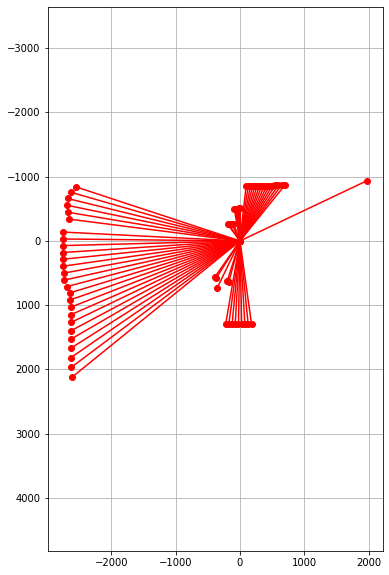

In [50]:
%matplotlib inline

# for i in range(3325):
#     _id = 7900+i
#     if _id in matched:
# #         display.display(plt.gcf())
# #         display.clear_output(wait=True)
        
#         scene_scane = lidar_points[lidar_points[:,0] == matched[_id][1]]


#         ox = np.sin(scene_scane[:,1]*np.pi/180) * scene_scane[:,2]
#         oy = np.cos(scene_scane[:,1]*np.pi/180) * scene_scane[:,2]
#         plt.figure(figsize=(6,10))
#         plt.plot([oy, np.zeros(np.size(oy))], [ox, np.zeros(np.size(oy))], "ro-") # lines from 0,0 to the 
#         plt.axis("equal")
#         bottom, top = plt.ylim()  # return the current ylim
#         plt.ylim((top, bottom)) # rescale y axis, to match the grid orientation
#         plt.grid(True)
#         plt.show()
        
#         time.sleep(0.1)

scene_scane = lidar_points[lidar_points[:,0] == matched[8169][1]]

ox = np.sin(scene_scane[:,1]*np.pi/180) * scene_scane[:,2]
oy = np.cos(scene_scane[:,1]*np.pi/180) * scene_scane[:,2]
plt.figure(figsize=(6,10))
plt.plot([oy, np.zeros(np.size(oy))], [ox, np.zeros(np.size(oy))], "ro-") # lines from 0,0 to the 
plt.axis("equal")
bottom, top = plt.ylim()  # return the current ylim
plt.ylim((top, bottom)) # rescale y axis, to match the grid orientation
plt.grid(True)
plt.show()

#### Align depth and color image to gether

In [3]:
def show_color_img(color_frame):
    color = np.asanyarray(color_frame.get_data())
    plt.rcParams["axes.grid"] = False
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.imshow(color)
    plt.show()
    
def show_depth_img(depth_frame):
    colorizer = rs.colorizer()
    colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
    plt.imshow(colorized_depth)
    plt.show()

In [4]:
# Create pipeline
pipeline = rs.pipeline()

# Create a config object
config = rs.config()

rs.config.enable_device_from_file(config, bag_file)

config.enable_stream(rs.stream.depth)
config.enable_stream(rs.stream.color)
    

# Start streaming from file
pipeline_profile = pipeline.start(config)


# skip 233 frame
print("Skipp frames")
for i in range(233):
    pipeline.wait_for_frames()


composite_frame = pipeline.wait_for_frames()
color_frame = composite_frame.get_color_frame()
depth_frame = composite_frame.get_depth_frame()

# Cleanup:
pipeline.stop()
print("Frames Captured")

Skipp frames
Frames Captured


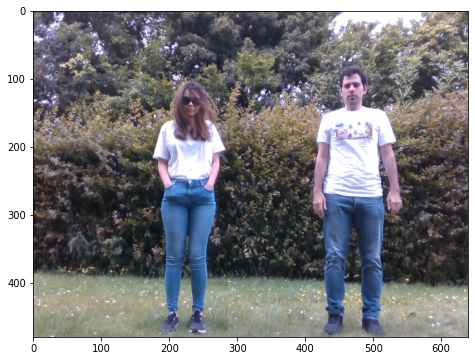

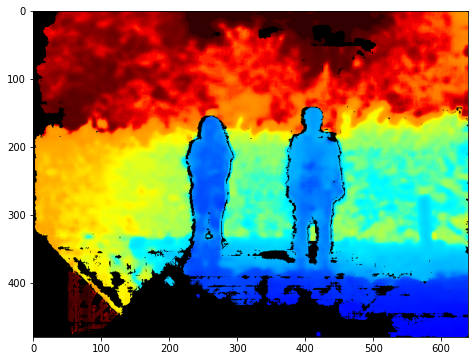

In [8]:
%matplotlib inline
color = np.asanyarray(color_frame.get_data())
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.imshow(color)
plt.show()

colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
plt.imshow(colorized_depth)
plt.show()

In [11]:
align = rs.align(rs.stream.color)
composite_frame = align.process(composite_frame)

# Update color and depth frames:
aligned_depth_frame = composite_frame.get_depth_frame()
colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

# Show the two frames together:
images = np.hstack((color, colorized_depth))
plt.imshow(images)
plt.show()
images = np.vstack((color, colorized_depth))
plt.imshow(images)
plt.show()

In [ ]:
def get_depth(x,y, depth_intrinsic):
    depth_intrin = depth_frame.profile.as_video_stream_profile().intrinsics
    depth_pixel = np.array([depth_color_frame.width*3/4, depth_color_frame.height*3/4]).astype(int)
    pixel_distance_in_meters = depth_frame.get_distance(x,y)
    
    

In [21]:
import numpy_indexed as npi


lidar_points = np.load("/home/eam/MasterThesis/Thesis/deep-sort3d/notebooks/2d_scan_ds_20211119-122933.npy")
ts = np.unique(lidar_points[:,0])
print(ts.shape)

(14135,)


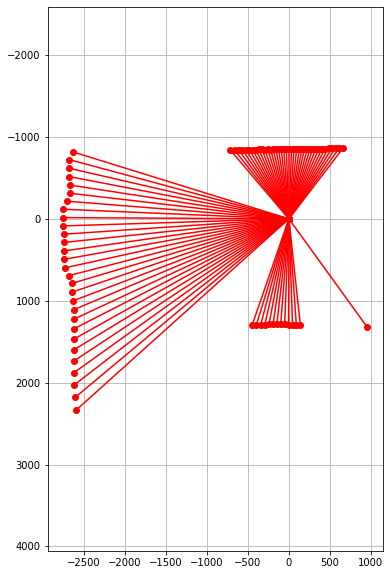

In [23]:
%matplotlib inline

# for i in range(len(ts)):
# # #     _id = ts[i]
#     display.display(plt.gcf())
#     display.clear_output(wait=True)

scene_scane = lidar_points[lidar_points[:,0] == ts[1000]]


ox = np.sin(scene_scane[:,1]*np.pi/180) * scene_scane[:,2]
oy = np.cos(scene_scane[:,1]*np.pi/180) * scene_scane[:,2]
plt.figure(figsize=(6,10))
plt.plot([oy, np.zeros(np.size(oy))], [ox, np.zeros(np.size(oy))], "ro-") # lines from 0,0 to the 
plt.axis("equal")
bottom, top = plt.ylim()  # return the current ylim
plt.ylim((top, bottom)) # rescale y axis, to match the grid orientation
plt.grid(True)
plt.show()

time.sleep(0.1)